<a href="https://colab.research.google.com/github/Vidhuran-Rajendran/Book-Recommendation-System_capstone-4/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

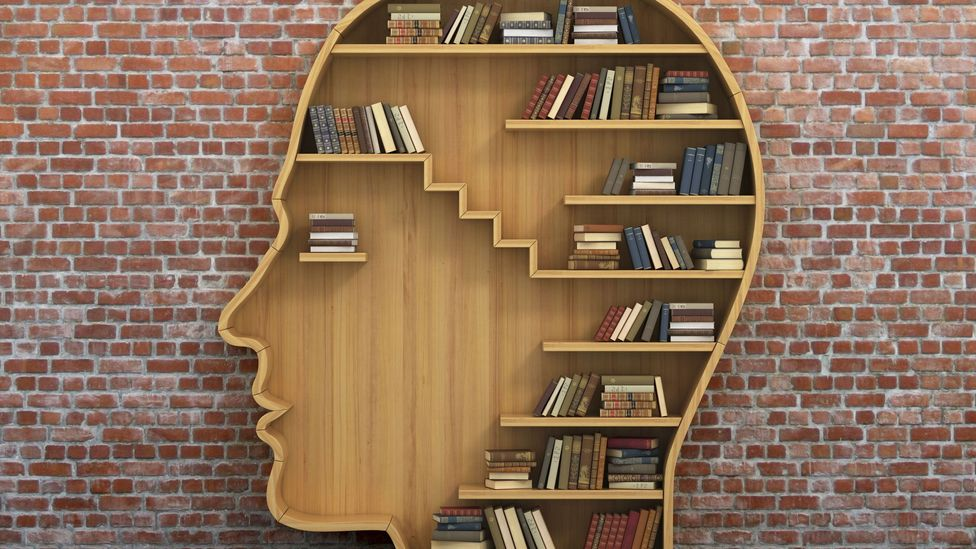

#**Book Recommendation System**

## <b> Problem Description </b>

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such
web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.
In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).
- Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. 

**The main objective is to create a book recommendation system for users.**

## <b> Data Description </b>

The Book-Crossing dataset comprises 3 files.<br>
● Users :<br>
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.<br>
● Books : <br>
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.<br>
● Ratings :<br> 
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0.

# **Importing**

In [35]:
# importing required packages
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# importing dataset and reading
books=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ALma better/Capstone project/Capstone_4/data_book_recommendation/Books.csv')
users=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ALma better/Capstone project/Capstone_4/data_book_recommendation/Users.csv')
ratings=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ALma better/Capstone project/Capstone_4/data_book_recommendation/Ratings.csv')

# **Data Inspection**

In [38]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [39]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [40]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [41]:
# looking into shape of dataset
print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


In [42]:
# looking into information(datatype,columns,null/non-null count)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [43]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [44]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


## **Pre-Processing**

### **Books**

In [45]:
print('columns:',list(books.columns))
books.head()

columns: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [46]:
# Drop URL comlumns
books.drop(['Image-URL-S','Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [47]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [48]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [49]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [50]:
## handling above missing values
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [51]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

- There are some names present in the year of publication, this need to be removed.

In [52]:
pd.set_option('display.max_colwidth',-1)

In [53]:
books.loc[books['Year-Of-Publication']== 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [54]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [55]:
# Handling mismatched values
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [56]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [57]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [58]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [59]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [60]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [61]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [62]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [63]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


# **Users**

In [67]:
print('columns: ',list(users.columns))
users.head()

columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [65]:
## checking null values
print(users.isna().sum())

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [66]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [68]:
required=users[users['Age']<=80]
required=required[required['Age']>=10]

In [69]:
## mean of ages
mean= round(required['Age'].mean())
mean

35

In [70]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int
list_ = users.Location.str.split(', ')

In [71]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values 
print(count_no_state)     #printing the states which didnt have any values

4659
16044


In [72]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)


In [73]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [74]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


### **Books-Ratings** 

In [75]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [76]:
## Checking for null values
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [77]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [78]:
## checking User-ID contains only number or not
print(is_numeric_dtype(ratings['User-ID']))

True


In [79]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [80]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [81]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [82]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [83]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [84]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
